In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import bisect


In [17]:
class Events():

    def __init__(self,events_file):
        self.t, self.x, self.y, self.p = self.extract_event_data(events_file)

    # Extracting the event data from the txt file provided
    def extract_event_data(self,events_file):
        t, x, y, p = [], [], [], []
        fileio = open(events_file,'r')
        for line in fileio:
            words = line.split(" ")
            t.append(float(words[0]))
            x.append(int(words[1]))
            y.append(int(words[2]))
            p.append(int(words[3]))
        fileio.close()
        return t, x, y, p



In [18]:
class Images():

    def __init__(self,images_file):
        self.t, self.frames_path, self.frames = self.extract_image_data(images_file)

    # Extracting the image data from the txt file provided
    def extract_image_data(self,images_file):
        t, frames_path, frames = [], [], []
        fileio = open(images_file,'r')
        for line in fileio:
            words = line.split(" ")
            t.append(float(words[0]))
            frames_path.append(words[1])
            frames.append(None) # Use frames.append(cv2.imread(words[2],cv2.IMREAD_GRAYSCALE)) to save the frame instead
        fileio.close()
        return t, frames_path, frames


In [19]:
class EVSandCISDataset():

    def __init__(self,events_file,images_file):
        self.events = Events(events_file)
        self.images = Images(images_file)
        self.h = max(self.events.x) + 1
        self.w = max(self.events.y) + 1

    # Creating an Event Image representation of a fixed time interval
    def make_event_image(self,start_time,end_time):
        if start_time < self.events.t[0] or end_time > self.events.t[-1]:
            print("Invalid Start/End Time Provided")
            return None
        event_img = np.zeros((self.w,self.h))
        idx = bisect.bisect_right(self.events.t,start_time)
        while self.events.t[idx] <= end_time:
            x, y, p = self.events.x[idx], self.events.y[idx], self.events.p[idx]
            event_img[y,x] += 2*p - 1
            idx += 1
        return event_img # event_img can also be normalized based on the requirement and application

    # Creating a Time Surface Representation of a Fixed Time Interval
    def make_time_surface(self,start_time,end_time,tau=50e-3):
        if start_time < self.events.t[0] or end_time > self.events.t[-1]:
            print("Invalid Start/End Time Provided")
            return None
        time_surface = np.zeros((self.w,self.h))
        idx = bisect.bisect_right(self.events.t,start_time)
        while self.events.t[idx] <= end_time:
            t, x, y, p = self.events.t[idx], self.events.x[idx], self.events.y[idx], self.events.p[idx]
            time_surface[y,x] = (2*p-1)*np.exp(-(end_time-t)/tau)
            idx += 1
        return time_surface # time_surface can also be normalized based on the requirement and application

    # Creating a Voxel Grid Representation of a Fixed Time Interval
    def make_spatio_temporal_voxel_grid(self,start_time,end_time,num_bins=5):
        if start_time < self.events.t[0] or end_time > self.events.t[-1]:
            print("Invalid Start/End Time Provided")
            return None
        event_imgs = []
        time_slice =  (end_time-start_time)/5
        voxel_ts = [start_time + i*time_slice for i in range(num_bins+1)]
        for i in range(num_bins):
            event_imgs.append(self.make_event_image(voxel_ts[i],voxel_ts[i+1]))
        voxel_grid = np.array(event_imgs)
        print(voxel_grid)
        return voxel_grid


[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [-1. -1. -1. ...  0.  0.  0.]
  [-1.  0. -1. ...  0.  0.  0.]
  [ 0. -1.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [-1.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [-1.  0.  0. ...  0.  0.  0.]
  [-1. -1.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0. -1.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]]


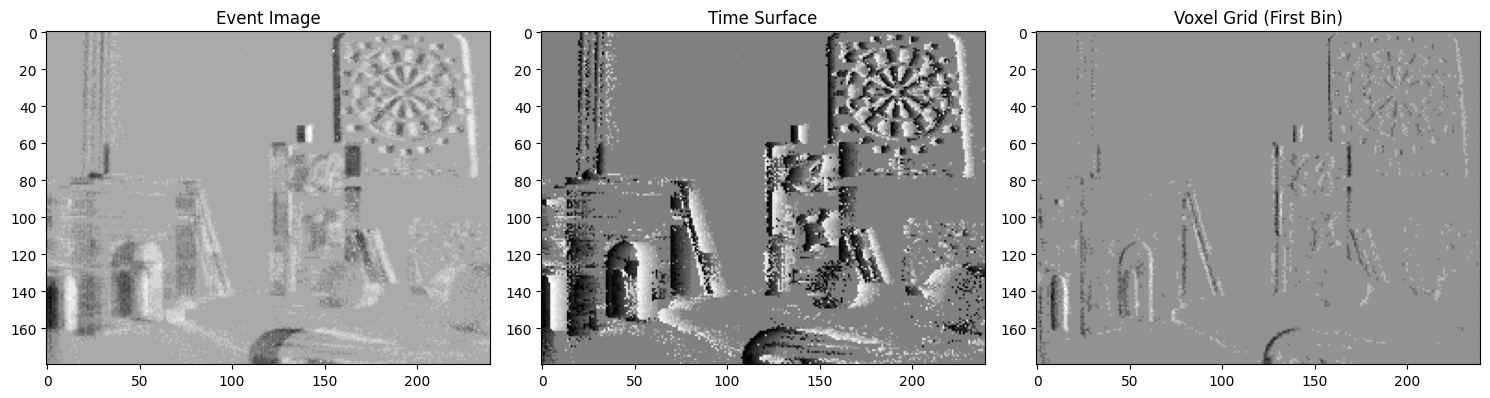

Done plotting


In [20]:
if __name__ == "__main__":

    slider_depth_data = EVSandCISDataset("events.txt","images.txt")
    event_img = slider_depth_data.make_event_image(0.01,0.1)
    time_surface = slider_depth_data.make_time_surface(0.01,0.1)
    voxel_grid = slider_depth_data.make_spatio_temporal_voxel_grid(0.01,0.1)

    # Create a figure with 3 subplots
    plt.figure(figsize=(15, 5))
    
    # Plot event image
    plt.subplot(1, 3, 1)
    plt.imshow(event_img, cmap='gray')
    plt.title('Event Image')
    
    # Plot time surface
    plt.subplot(1, 3, 2)
    plt.imshow(time_surface, cmap='gray')
    plt.title('Time Surface')
    
    # Plot first frame of voxel grid
    plt.subplot(1, 3, 3)
    plt.imshow(voxel_grid[0], cmap='gray')
    plt.title('Voxel Grid (First Bin)')
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    print('Done plotting')
